In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

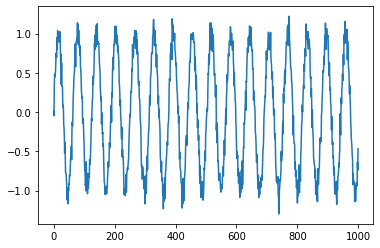

In [2]:
# make the original data
N = 1000
series = np.sin(0.1*np.arange(N)) + np.random.randn(N) * 0.1

# plot it
plt.plot(series)
plt.show()

In [3]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (990, 10, 1) Y.shape (990, 1)


In [4]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [5]:
### Define simple RNN
class SimpleRNN(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    super(SimpleRNN, self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    # note: batch_first=True
    # applies the convention that our data will be of shape:
    # (num_samples, sequence_length, num_features)
    # rather than:
    # (sequence_length, num_samples, num_features)
    self.rnn = nn.RNN(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        nonlinearity='relu',
        batch_first=True)
    self.fc = nn.Linear(self.M, self.K)
  
  def forward(self, X):
    # initial hidden states
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    # get RNN unit output
    # out is of size (N, T, M)
    # 2nd return value is hidden states at each hidden layer
    # we don't need those now
    out, _ = self.rnn(X, h0)

    # we only want h(T) at the final time step
    # N x M -> N x K
    out = self.fc(out[:, -1, :])
    return out

In [6]:
# Instantiate the model
model = SimpleRNN(n_inputs=1, n_hidden=15, n_rnnlayers=1, n_outputs=1)
model.to(device)

SimpleRNN(
  (rnn): RNN(1, 15, batch_first=True)
  (fc): Linear(in_features=15, out_features=1, bias=True)
)

In [7]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
# Make inputs and targets
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [9]:
# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [10]:
# Training
def full_gd(model,
            criterion,
            optimizer,
            X_train,
            y_train,
            X_test,
            y_test,
            epochs=1000):

  # Stuff to store
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    # zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
      
    # Backward and optimize
    loss.backward()
    optimizer.step()

    # Save losses
    train_losses[it] = loss.item()

    # Test loss
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[it] = test_loss.item()
      
    if (it + 1) % 5 == 0:
      print(f'Epoch {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
  
  return train_losses, test_losses

In [11]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test)

Epoch 5/1000, Train Loss: 0.5411, Test Loss: 0.5401
Epoch 10/1000, Train Loss: 0.5243, Test Loss: 0.5233
Epoch 15/1000, Train Loss: 0.5070, Test Loss: 0.5058
Epoch 20/1000, Train Loss: 0.4886, Test Loss: 0.4871
Epoch 25/1000, Train Loss: 0.4688, Test Loss: 0.4671
Epoch 30/1000, Train Loss: 0.4475, Test Loss: 0.4453
Epoch 35/1000, Train Loss: 0.4241, Test Loss: 0.4215
Epoch 40/1000, Train Loss: 0.3984, Test Loss: 0.3953
Epoch 45/1000, Train Loss: 0.3701, Test Loss: 0.3664
Epoch 50/1000, Train Loss: 0.3393, Test Loss: 0.3349
Epoch 55/1000, Train Loss: 0.3055, Test Loss: 0.3004
Epoch 60/1000, Train Loss: 0.2684, Test Loss: 0.2626
Epoch 65/1000, Train Loss: 0.2282, Test Loss: 0.2218
Epoch 70/1000, Train Loss: 0.1855, Test Loss: 0.1785
Epoch 75/1000, Train Loss: 0.1416, Test Loss: 0.1343
Epoch 80/1000, Train Loss: 0.0982, Test Loss: 0.0918
Epoch 85/1000, Train Loss: 0.0639, Test Loss: 0.0606
Epoch 90/1000, Train Loss: 0.0483, Test Loss: 0.0487
Epoch 95/1000, Train Loss: 0.0448, Test Loss: 0

Epoch 790/1000, Train Loss: 0.0116, Test Loss: 0.0140
Epoch 795/1000, Train Loss: 0.0116, Test Loss: 0.0140
Epoch 800/1000, Train Loss: 0.0116, Test Loss: 0.0140
Epoch 805/1000, Train Loss: 0.0116, Test Loss: 0.0141
Epoch 810/1000, Train Loss: 0.0116, Test Loss: 0.0140
Epoch 815/1000, Train Loss: 0.0116, Test Loss: 0.0140
Epoch 820/1000, Train Loss: 0.0116, Test Loss: 0.0140
Epoch 825/1000, Train Loss: 0.0116, Test Loss: 0.0141
Epoch 830/1000, Train Loss: 0.0116, Test Loss: 0.0141
Epoch 835/1000, Train Loss: 0.0115, Test Loss: 0.0140
Epoch 840/1000, Train Loss: 0.0115, Test Loss: 0.0140
Epoch 845/1000, Train Loss: 0.0115, Test Loss: 0.0140
Epoch 850/1000, Train Loss: 0.0115, Test Loss: 0.0140
Epoch 855/1000, Train Loss: 0.0115, Test Loss: 0.0140
Epoch 860/1000, Train Loss: 0.0115, Test Loss: 0.0140
Epoch 865/1000, Train Loss: 0.0115, Test Loss: 0.0140
Epoch 870/1000, Train Loss: 0.0115, Test Loss: 0.0140
Epoch 875/1000, Train Loss: 0.0115, Test Loss: 0.0141
Epoch 880/1000, Train Loss: 

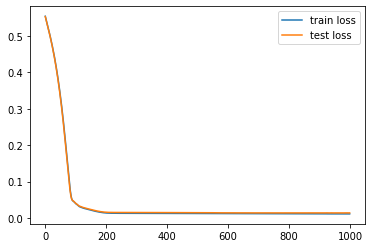

In [12]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [13]:
# "Wrong" forecast using true targets

validation_target = Y[-N//2:]
validation_predictions = []

# index of first validation input
i = 0

while len(validation_predictions) < len(validation_target):
  input_ = X_test[i].reshape(1, T, 1)
  p = model(input_)[0,0].item() # 1x1 array -> scalar
  i += 1
  
  # update the predictions list
  validation_predictions.append(p)

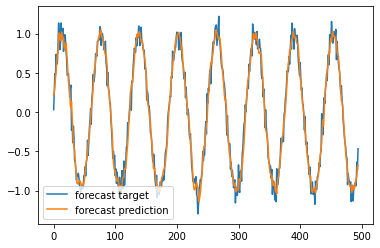

In [14]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend();

In [15]:
# Forecast future values (use only self-predictions for making future predictions)

validation_target = Y[-N//2:]
validation_predictions = []

# last train input
# last_x = torch.from_numpy(X[-N//2]) # 1-D array of length T
# last_x = torch.from_numpy(X[-N//2].astype(np.float32))
last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
  input_ = last_x.reshape(1, T, 1)
  p = model(input_)
  # [0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p[0,0].item())
  
  # make the new input
  last_x = torch.cat((last_x[1:], p[0]))

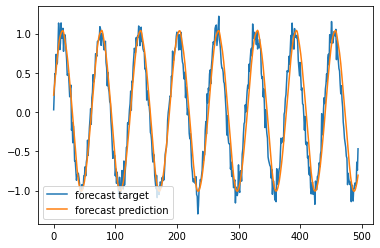

In [16]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()